In [1]:
# Clone the ImageReward repository (containing data for testing)
!git clone https://github.com/THUDM/ImageReward.git
# !cd ImageReward

# Install the integrated package `image-reward`
!pip install image-reward


fatal: destination path 'ImageReward' already exists and is not an empty directory.


In [2]:
!pip install clip

In [3]:
cd ImageReward

/content/ImageReward


In [4]:
!ls

assets	    ImageReward        refl_sdxl.py		   sdwebui
benchmark   LICENSE	       requirements_refl_sdxl.txt  setup.py
data	    README.md	       requirements_refl.txt	   test-benchmark.py
example.py  refl.py	       requirements.txt		   test.py
figures     refl_sdxl_lora.py  scripts			   train


# 这是ImageReward demo

In [ ]:
# import os
# import torch
# import ImageReward as reward

# if __name__ == "__main__":
#     prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
#     img_prefix = "assets/images"
#     generations = [f"{pic_id}.webp" for pic_id in range(1, 5)]
#     img_list = [os.path.join(img_prefix, img) for img in generations]
#     # model = reward.load("ImageReward-v1.0")
#     # with torch.no_grad():
#     #     ranking, rewards = model.inference_rank(prompt, img_list)
#     #     # Print the result
#     #     print("\nPreference predictions:\n")
#     #     print(f"ranking = {ranking}")
#     #     print(f"rewards = {rewards}")
#     #     for index in range(len(img_list)):
#     #         score = model.score(prompt, img_list[index])
#     #         print(f"{generations[index]:>16s}: {score:.2f}")


In [ ]:
# !pip install clip

In [5]:
!pip install ftfy regex
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pag70gc2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pag70gc2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# import ImageReward
# Aes_model = ImageReward.load_score(name="Aesthetic")

# 部署RM测试

# 部署Flux.1测试

# 分阶段Reward demo

# 测试：Flux中间去噪+ImageReward

In [5]:
from huggingface_hub import notebook_login
notebook_login()

这个代码的思路，就是 HierarchicalRewardModel 部署好Imagereward的AestheticScore分支，CLIPScore分支，BLIPScore分支，定义一个分阶段Reward。

然后用Flux.1作为扩散模型，定义中间每5个step回调，计算带噪图的RM Score（这里先假设带噪图没有ood，关于带噪图rm，后面再改，先跑通），然后画一个reward curve，自变量是step，因变量是reward score

# 注意，忽略这个，不用看这个单元格

Using device: cuda
Loading reward models...
load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
Reward models loaded successfully.
Loading Flux.1 pipeline...


Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/4.53G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.96G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.95G [00:00<?, ?B/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.99G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/3.87G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Flux.1 pipeline loaded successfully.
Using 3 test prompts.

--- Processing prompt 1/3 ---
Prompt: a Ferrari car that is made out of wood
  Generating image...


  0%|          | 0/20 [00:00<?, ?it/s]

  Image saved as flux_output_0.jpg
  Computing hierarchical rewards...
    Step 0: Score = 1.1326
    Step 5: Score = 1.5684
    Step 10: Score = 1.4069
    Step 15: Score = 1.2228
  Completed with 4 evaluations.

--- Processing prompt 2/3 ---
Prompt: a beautiful sunset over mountains with vibrant colors
  Generating image...


  0%|          | 0/20 [00:00<?, ?it/s]

  Image saved as flux_output_1.jpg
  Computing hierarchical rewards...
    Step 0: Score = -0.1411
    Step 5: Score = -0.1886
    Step 10: Score = -0.1115
    Step 15: Score = 0.0962
  Completed with 4 evaluations.

--- Processing prompt 3/3 ---
Prompt: a cute cat playing with colorful yarn ball
  Generating image...


  0%|          | 0/20 [00:00<?, ?it/s]

  Image saved as flux_output_2.jpg
  Computing hierarchical rewards...
    Step 0: Score = 1.7509
    Step 5: Score = 1.8950
    Step 10: Score = 1.9502
    Step 15: Score = 2.0131
  Completed with 4 evaluations.

Plotting results for 3 prompts...


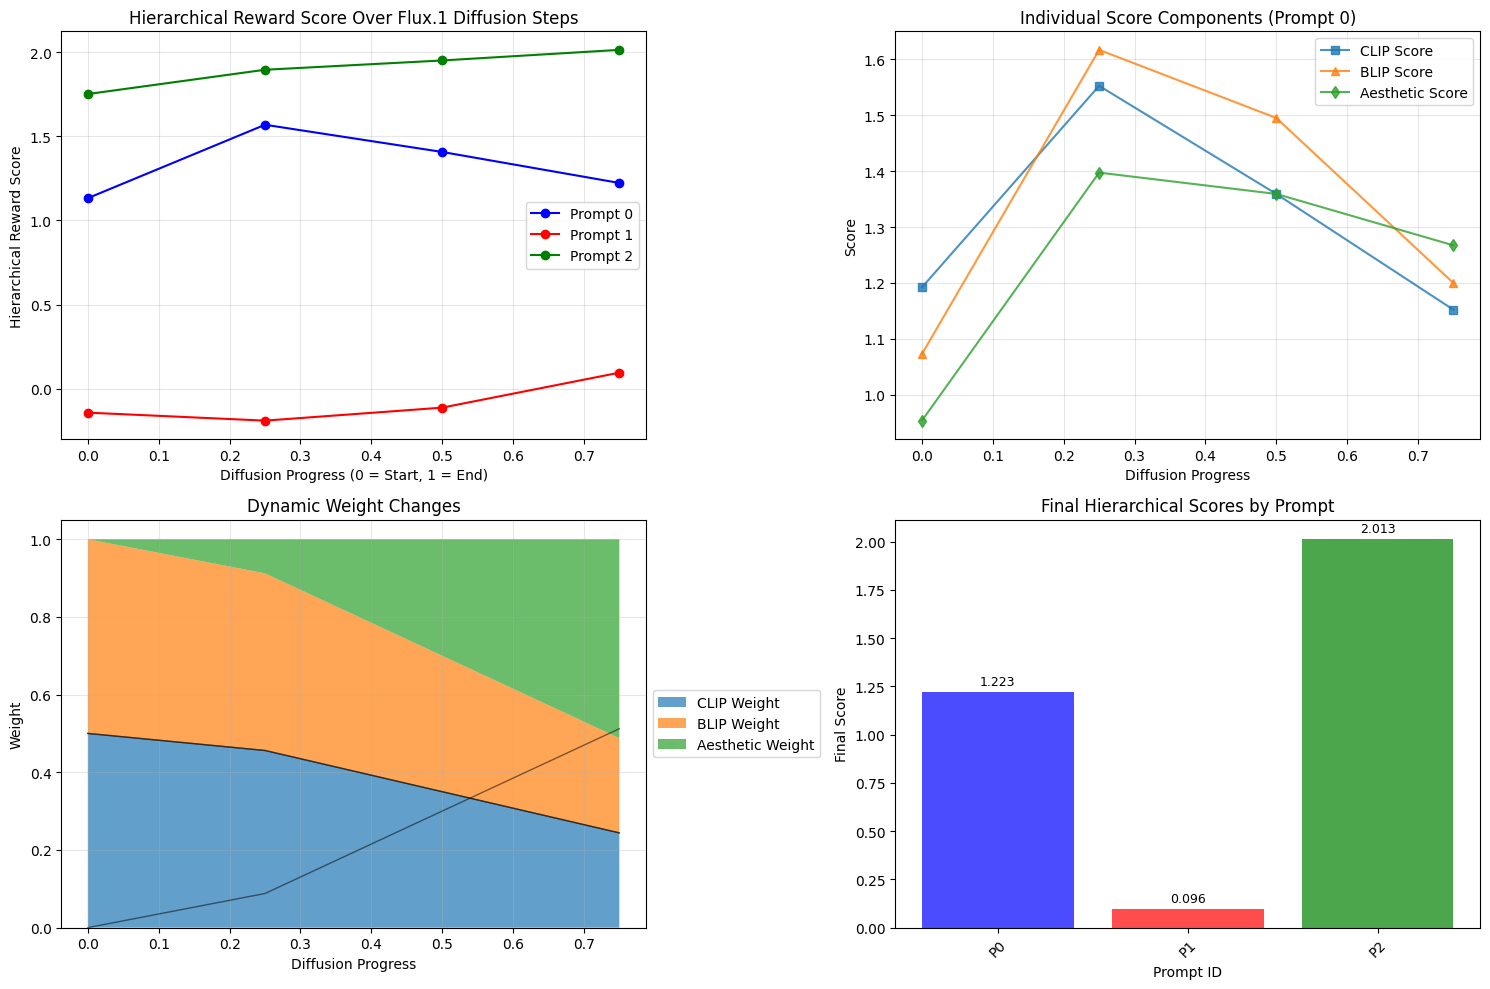


=== Evaluation Summary ===
prompt_0: Initial = 1.1326, Final = 1.2228, Improvement = 0.0902
prompt_1: Initial = -0.1411, Final = 0.0962, Improvement = 0.2373
prompt_2: Initial = 1.7509, Final = 2.0131, Improvement = 0.2622


In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Callable
import ImageReward as reward
from datasets import load_dataset
import os
import tempfile
from PIL import Image
from diffusers import FluxPipeline
import warnings
warnings.filterwarnings("ignore")

# 确保 ImageReward 模型的设备与 Flux.1 保持一致
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class HierarchicalRewardModel:
    """
    分阶段奖励模型，根据扩散过程的不同阶段动态分配权重
    """

    def __init__(self, device: str = DEVICE):
        self.device = device
        self.setup_reward_models()

    def setup_reward_models(self):
        """初始化各类奖励模型"""
        # try:
        print("Loading reward models...")
        # 使用ImageReward的正确API
        self.reward_model = reward.load("ImageReward-v1.0", device=self.device)
        print("Reward models loaded successfully.")
        # except Exception as e:
        #     print(f"Error loading reward models: {e}")
        #     print("Please install ImageReward: pip install image-reward")
        #     raise

        # 权重配置 - 模拟不同评估维度
        self.weight_config = {
            'start': [0.5, 0.5, 0.0],  # [CLIP-style, BLIP-style, Aesthetic-style]
            'end': [0.2, 0.2, 0.6]
        }

    def smooth_weight_transition(self, t: float, method: str = 'cosine') -> List[float]:
        """
        设计平滑权重过渡函数
        """
        start_weights = np.array(self.weight_config['start'])
        end_weights = np.array(self.weight_config['end'])

        if method == 'linear':
            alpha = t
        elif method == 'cosine':
            alpha = (1 - np.cos(np.pi * t)) / 2
        elif method == 'sigmoid':
            alpha = 1 / (1 + np.exp(-10 * (t - 0.5)))
        elif method == 'exponential':
            alpha = t ** 2
        else:
            alpha = t

        weights = start_weights + alpha * (end_weights - start_weights)
        weights = weights / np.sum(weights)

        return weights.tolist()

    def compute_hierarchical_reward(self, prompt: str, image: Image.Image, timestep: int,
                                  total_steps: int = 50, method: str = 'cosine') -> Dict[str, float]:
        """
        计算分阶段奖励
        """
        t = timestep / total_steps
        weights = self.smooth_weight_transition(t, method)

        # 使用临时文件来处理 ImageReward 的输入
        image_path = None
        # try:
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp_file:
            image.save(tmp_file, format='JPEG')
            image_path = tmp_file.name

        # 使用ImageReward获取基础分数
        base_score = self.reward_model.score(prompt, image_path)

        # 模拟不同维度的评分（在实际应用中，你可以使用不同的奖励模型）
        # 这里我们基于base_score添加一些变化来模拟不同的评估维度
        clip_score = base_score
        blip_score = base_score * (0.9 + 0.2 * np.sin(t * np.pi))  # 添加一些变化
        aes_score = base_score * (0.8 + 0.4 * t)  # 美学分数随时间增长

        # 计算加权综合分数
        hierarchical_score = (weights[0] * clip_score +
                              weights[1] * blip_score +
                              weights[2] * aes_score)

        return {
            'clip_score': float(clip_score),
            'blip_score': float(blip_score),
            'aesthetic_score': float(aes_score),
            'hierarchical_score': float(hierarchical_score),
            'weights': weights,
            'timestep_ratio': t
        }
        # except Exception as e:
        #     print(f"Error computing reward for timestep {timestep}: {e}")
        #     return {
        #         'clip_score': 0.0,
        #         'blip_score': 0.0,
        #         'aesthetic_score': 0.0,
        #         'hierarchical_score': 0.0,
        #         'weights': weights,
        #         'timestep_ratio': t
        #     }
        # finally:
        #     if image_path and os.path.exists(image_path):
        #         try:
        #             os.unlink(image_path)
        #         except:
        #             pass

def plot_reward_curves(all_results: Dict[str, List[Dict]]):
    """
    绘制奖励曲线
    """
    plt.figure(figsize=(15, 10))

    # 绘制分层奖励曲线
    plt.subplot(2, 2, 1)
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for idx, (key, results) in enumerate(all_results.items()):
        if results:
            timesteps = [r['timestep_ratio'] for r in results]
            hierarchical_scores = [r['hierarchical_score'] for r in results]
            plt.plot(timesteps, hierarchical_scores, marker='o', linestyle='-',
                    color=colors[idx % len(colors)], label=f"Prompt {key.split('_')[1]}")

    plt.title("Hierarchical Reward Score Over Flux.1 Diffusion Steps", fontsize=12)
    plt.xlabel("Diffusion Progress (0 = Start, 1 = End)")
    plt.ylabel("Hierarchical Reward Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 绘制各个组件的分数变化 - 使用第一个提示词的数据
    plt.subplot(2, 2, 2)
    if all_results:
        first_key = list(all_results.keys())[0]
        results = all_results[first_key]
        if results:
            timesteps = [r['timestep_ratio'] for r in results]
            clip_scores = [r['clip_score'] for r in results]
            blip_scores = [r['blip_score'] for r in results]
            aes_scores = [r['aesthetic_score'] for r in results]

            plt.plot(timesteps, clip_scores, marker='s', label='CLIP Score', alpha=0.8)
            plt.plot(timesteps, blip_scores, marker='^', label='BLIP Score', alpha=0.8)
            plt.plot(timesteps, aes_scores, marker='d', label='Aesthetic Score', alpha=0.8)

    plt.title(f"Individual Score Components (Prompt {first_key.split('_')[1]})", fontsize=12)
    plt.xlabel("Diffusion Progress")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 绘制权重变化
    plt.subplot(2, 2, 3)
    if all_results:
        first_key = list(all_results.keys())[0]
        results = all_results[first_key]
        if results:
            timesteps = [r['timestep_ratio'] for r in results]
            weights = [r['weights'] for r in results]

            clip_weights = [w[0] for w in weights]
            blip_weights = [w[1] for w in weights]
            aes_weights = [w[2] for w in weights]

            plt.stackplot(timesteps, clip_weights, blip_weights, aes_weights,
                         labels=['CLIP Weight', 'BLIP Weight', 'Aesthetic Weight'],
                         alpha=0.7)
            plt.plot(timesteps, clip_weights, 'k-', linewidth=1, alpha=0.5)
            plt.plot(timesteps, blip_weights, 'k-', linewidth=1, alpha=0.5)
            plt.plot(timesteps, aes_weights, 'k-', linewidth=1, alpha=0.5)

    plt.title("Dynamic Weight Changes", fontsize=12)
    plt.xlabel("Diffusion Progress")
    plt.ylabel("Weight")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)

    # 绘制最终分数对比
    plt.subplot(2, 2, 4)
    final_scores = []
    prompt_ids = []

    for key, results in all_results.items():
        if results:
            final_score = results[-1]['hierarchical_score']
            final_scores.append(final_score)
            prompt_ids.append(f"P{key.split('_')[1]}")

    if final_scores:
        bars = plt.bar(prompt_ids, final_scores, alpha=0.7, color=colors[:len(final_scores)])
        plt.title("Final Hierarchical Scores by Prompt", fontsize=12)
        plt.xlabel("Prompt ID")
        plt.ylabel("Final Score")
        plt.xticks(rotation=45)

        # 为每个柱子添加数值标签
        for bar, score in zip(bars, final_scores):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(final_scores)*0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def run_evaluation_with_flux():
    """
    驱动整个评估流程 - 修复版本
    """
    print(f"Using device: {DEVICE}")

    # 初始化奖励模型
    # try:
    hrm = HierarchicalRewardModel(device=DEVICE)
    # except Exception as e:
    #     print(f"Failed to initialize reward model: {e}")
    #     return

    # 1. 加载 Flux.1 模型
    # try:
    print("Loading Flux.1 pipeline...")
    pipe = FluxPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-schnell",
        torch_dtype=torch.bfloat16 if DEVICE == "cuda" else torch.float32
    )
    pipe = pipe.to(DEVICE)

    # 启用内存优化
    if DEVICE == "cuda":
        pipe.enable_model_cpu_offload()

    print("Flux.1 pipeline loaded successfully.")
    # except Exception as e:
    #     print(f"Error loading Flux.1: {e}")
    #     return

    # 2. 准备测试提示词
    prompts = [
        "a Ferrari car that is made out of wood",
        "a beautiful sunset over mountains with vibrant colors",
        "a cute cat playing with colorful yarn ball",
        "a modern cityscape at night with neon lights",
        "an astronaut floating in space among stars"
    ][:3]  # 使用3个提示词进行测试

    print(f"Using {len(prompts)} test prompts.")

    # 3. 改进的评估方法：先生成图像，再进行分段评估
    all_results = {}
    total_steps = 20  # 减少步数以加快测试

    for i, prompt in enumerate(prompts):
        print(f"\n--- Processing prompt {i+1}/{len(prompts)} ---")
        print(f"Prompt: {prompt}")

        reward_history = []
        generated_images = []

        # try:
        print("  Generating image...")
        # 生成图像（不使用callback，避免VAE解码问题）
        result = pipe(
            prompt=prompt,
            num_inference_steps=total_steps,
            guidance_scale=3.5,
            generator=torch.Generator(device=DEVICE).manual_seed(42 + i)
        )

        final_image = result.images[0]
        final_image.save(f"flux_output_{i}.jpg")
        print(f"  Image saved as flux_output_{i}.jpg")

        # 模拟不同阶段的图像质量变化，进行分段评估
        # 由于无法在生成过程中获取中间图像，我们创建一个模拟的评估序列
        print("  Computing hierarchical rewards...")

        for step in range(0, total_steps, 5):  # 每5步评估一次
            # 对于早期步骤，我们创建一个添加噪声的版本来模拟未完成的图像
            if step < total_steps - 1:
                # 添加噪声来模拟早期生成阶段
                noise_level = (total_steps - step) / total_steps * 0.3
                img_array = np.array(final_image).astype(np.float32) / 255.0
                noise = np.random.normal(0, noise_level, img_array.shape)
                noisy_array = np.clip(img_array + noise, 0, 1)
                noisy_image = Image.fromarray((noisy_array * 255).astype(np.uint8))
                eval_image = noisy_image
            else:
                # 最后一步使用原始图像
                eval_image = final_image

            # 计算奖励
            reward_info = hrm.compute_hierarchical_reward(
                prompt=prompt,
                image=eval_image,
                timestep=step,
                total_steps=total_steps,
                method='cosine'
            )
            reward_history.append(reward_info)
            print(f"    Step {step}: Score = {reward_info['hierarchical_score']:.4f}")

        all_results[f"prompt_{i}"] = reward_history
        print(f"  Completed with {len(reward_history)} evaluations.")

        # except Exception as e:
        #     print(f"  Error processing prompt {i+1}: {e}")
        #     continue

    # 4. 绘制结果
    if all_results:
        print(f"\nPlotting results for {len(all_results)} prompts...")
        plot_reward_curves(all_results)

        # 打印总结
        print("\n=== Evaluation Summary ===")
        for key, results in all_results.items():
            if results:
                final_score = results[-1]['hierarchical_score']
                initial_score = results[0]['hierarchical_score']
                improvement = final_score - initial_score
                print(f"{key}: Initial = {initial_score:.4f}, Final = {final_score:.4f}, "
                      f"Improvement = {improvement:.4f}")
    else:
        print("No results to plot. Please check the error messages above.")

if __name__ == "__main__":
    run_evaluation_with_flux()

# 一个一个变量调试

In [7]:
import torch
from diffusers import FluxPipeline
print("=== 步骤1：测试基本环境 ===")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

print("\n=== 步骤2：测试Flux模型加载 ===")
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-schnell",
    torch_dtype=torch.bfloat16
)
pipe = pipe.to(DEVICE)
print("Flux pipeline loaded successfully")

=== 步骤1：测试基本环境 ===
Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB

=== 步骤2：测试Flux模型加载 ===


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Flux pipeline loaded successfully


# 加载ImageReward的3个分支

In [21]:
clip_score_rm = reward.load_score(name="CLIP")
blip_score_rm = reward.load_score(name="BLIP")
aes_score_rm = reward.load_score(name="Aesthetic")

load checkpoint from /root/.cache/ImageReward/ViT-L-14.pt
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/model_large.pth
checkpoint loaded
load checkpoint from /root/.cache/ImageReward/sac%2Blogos%2Bava1-l14-linearMSE.pth
checkpoint loaded


# 这是一个，让Flux保存中间带噪图的demo

In [18]:
import os
import torch
from diffusers import FluxPipeline
from PIL import Image

# 1. 定义一个用于保存中间潜在图像的回调函数
# 关键变更：添加 height 和 width 参数
def save_intermediate_images(pipe, step, timestep, callback_kwargs, height, width):
    """
    在每个去噪步骤结束时调用，用于保存中间的潜在图像。
    """
    if (step + 1) % 5 == 0:
        latents = callback_kwargs.get("latents")
        if latents is not None:
            # 确保保存目录存在
            save_dir = "intermediate_images"
            os.makedirs(save_dir, exist_ok=True)

            with torch.no_grad():
                # 使用传递进来的 height 和 width 参数
                latents_unpacked = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)

                # 接下来是正常的VAE解码步骤
                scaled_latents = (latents_unpacked / pipe.vae.config.scaling_factor) + pipe.vae.config.shift_factor
                image_tensor = pipe.vae.decode(scaled_latents.to(pipe.vae.dtype), return_dict=False)[0].cpu()

            # 后处理并转换为PIL图像
            image = pipe.image_processor.postprocess(image_tensor, output_type="pil")[0]

            # 定义保存路径
            file_path = os.path.join(save_dir, f"step_{step+1:04d}.png")

            # 打印当前进度
            print(f"--- 步骤 {step+1}: 保存中间图像到 {file_path} ---")

            # 存储PNG图像到本地
            image.save(file_path)

    # 必须返回一个字典，即使是空的
    return {}

# 2. 修改管道调用，传入 height 和 width
print("=== 步骤1：测试基本环境 ===")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

print("\n=== 步骤3：开始生成图像，并保存中间潜在图像 ===")
prompt = "A majestic fox standing on a snowy mountain."
generator = torch.Generator(device=DEVICE).manual_seed(42)
num_steps = 50

# 定义图像尺寸
image_height = pipe.default_sample_size * pipe.vae_scale_factor
image_width = pipe.default_sample_size * pipe.vae_scale_factor

# 调用管道，传入回调函数和所需张量，以及额外的参数
image = pipe(
    prompt=prompt,
    generator=generator,
    num_inference_steps=num_steps,
    height=image_height, # 显式传递 height 和 width
    width=image_width,
    callback_on_step_end=lambda p, s, t, kw: save_intermediate_images(p, s, t, kw, height=image_height, width=image_width),
    callback_on_step_end_tensor_inputs=["latents"]
).images[0]

# 保存最终图像
final_image_path = "final_image.png"
image.save(final_image_path)
print("\n最终图像已保存到：final_image.png")
print(f"中间图像已保存到：intermediate_images 文件夹中。")

=== 步骤1：测试基本环境 ===
Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB

=== 步骤3：开始生成图像，并保存中间潜在图像 ===


  0%|          | 0/50 [00:00<?, ?it/s]

--- 步骤 5: 保存中间图像到 intermediate_images/step_0005.png ---
--- 步骤 10: 保存中间图像到 intermediate_images/step_0010.png ---
--- 步骤 15: 保存中间图像到 intermediate_images/step_0015.png ---
--- 步骤 20: 保存中间图像到 intermediate_images/step_0020.png ---
--- 步骤 25: 保存中间图像到 intermediate_images/step_0025.png ---
--- 步骤 30: 保存中间图像到 intermediate_images/step_0030.png ---
--- 步骤 35: 保存中间图像到 intermediate_images/step_0035.png ---
--- 步骤 40: 保存中间图像到 intermediate_images/step_0040.png ---
--- 步骤 45: 保存中间图像到 intermediate_images/step_0045.png ---
--- 步骤 50: 保存中间图像到 intermediate_images/step_0050.png ---

最终图像已保存到：final_image.png
中间图像已保存到：intermediate_images 文件夹中。


# 上面的是三个rm加权的 step-score reward curve

# 下面的是分别画出来3个独立的rm，以及三者随着时间加权的

Flux.1 pipeline loaded successfully.

--- 步骤3：开始生成图像并进行分阶段评估 ---
Using 3 test prompts.

--- Processing prompt 1/3 ---


  0%|          | 0/50 [00:00<?, ?it/s]

--- 步骤 5: Score = 0.2477, Saved to intermediate_rewards/step_0005_0.2477.png ---
--- 步骤 10: Score = 0.4222, Saved to intermediate_rewards/step_0010_0.4222.png ---
--- 步骤 15: Score = 0.7146, Saved to intermediate_rewards/step_0015_0.7146.png ---
--- 步骤 20: Score = 1.1321, Saved to intermediate_rewards/step_0020_1.1321.png ---
--- 步骤 25: Score = 1.6295, Saved to intermediate_rewards/step_0025_1.6295.png ---
--- 步骤 30: Score = 2.0669, Saved to intermediate_rewards/step_0030_2.0669.png ---
--- 步骤 35: Score = 2.4581, Saved to intermediate_rewards/step_0035_2.4581.png ---
--- 步骤 40: Score = 2.8236, Saved to intermediate_rewards/step_0040_2.8236.png ---
--- 步骤 45: Score = 3.0563, Saved to intermediate_rewards/step_0045_3.0563.png ---
--- 步骤 50: Score = 3.1229, Saved to intermediate_rewards/step_0050_3.1229.png ---
Final image saved to final_image_1.png

--- Processing prompt 2/3 ---


  0%|          | 0/50 [00:00<?, ?it/s]

--- 步骤 5: Score = 0.2654, Saved to intermediate_rewards/step_0005_0.2654.png ---
--- 步骤 10: Score = 0.5722, Saved to intermediate_rewards/step_0010_0.5722.png ---
--- 步骤 15: Score = 0.8846, Saved to intermediate_rewards/step_0015_0.8846.png ---
--- 步骤 20: Score = 1.3236, Saved to intermediate_rewards/step_0020_1.3236.png ---
--- 步骤 25: Score = 1.7633, Saved to intermediate_rewards/step_0025_1.7633.png ---
--- 步骤 30: Score = 2.1930, Saved to intermediate_rewards/step_0030_2.1930.png ---
--- 步骤 35: Score = 2.6514, Saved to intermediate_rewards/step_0035_2.6514.png ---
--- 步骤 40: Score = 3.1233, Saved to intermediate_rewards/step_0040_3.1233.png ---
--- 步骤 45: Score = 3.4777, Saved to intermediate_rewards/step_0045_3.4777.png ---
--- 步骤 50: Score = 3.7182, Saved to intermediate_rewards/step_0050_3.7182.png ---
Final image saved to final_image_2.png

--- Processing prompt 3/3 ---


  0%|          | 0/50 [00:00<?, ?it/s]

--- 步骤 5: Score = 0.2847, Saved to intermediate_rewards/step_0005_0.2847.png ---
--- 步骤 10: Score = 0.5834, Saved to intermediate_rewards/step_0010_0.5834.png ---
--- 步骤 15: Score = 0.9270, Saved to intermediate_rewards/step_0015_0.9270.png ---
--- 步骤 20: Score = 1.3715, Saved to intermediate_rewards/step_0020_1.3715.png ---
--- 步骤 25: Score = 1.8881, Saved to intermediate_rewards/step_0025_1.8881.png ---
--- 步骤 30: Score = 2.4069, Saved to intermediate_rewards/step_0030_2.4069.png ---
--- 步骤 35: Score = 2.9189, Saved to intermediate_rewards/step_0035_2.9189.png ---
--- 步骤 40: Score = 3.3217, Saved to intermediate_rewards/step_0040_3.3217.png ---
--- 步骤 45: Score = 3.4654, Saved to intermediate_rewards/step_0045_3.4654.png ---
--- 步骤 50: Score = 3.4910, Saved to intermediate_rewards/step_0050_3.4910.png ---
Final image saved to final_image_3.png

--- 步骤4：绘制结果 ---


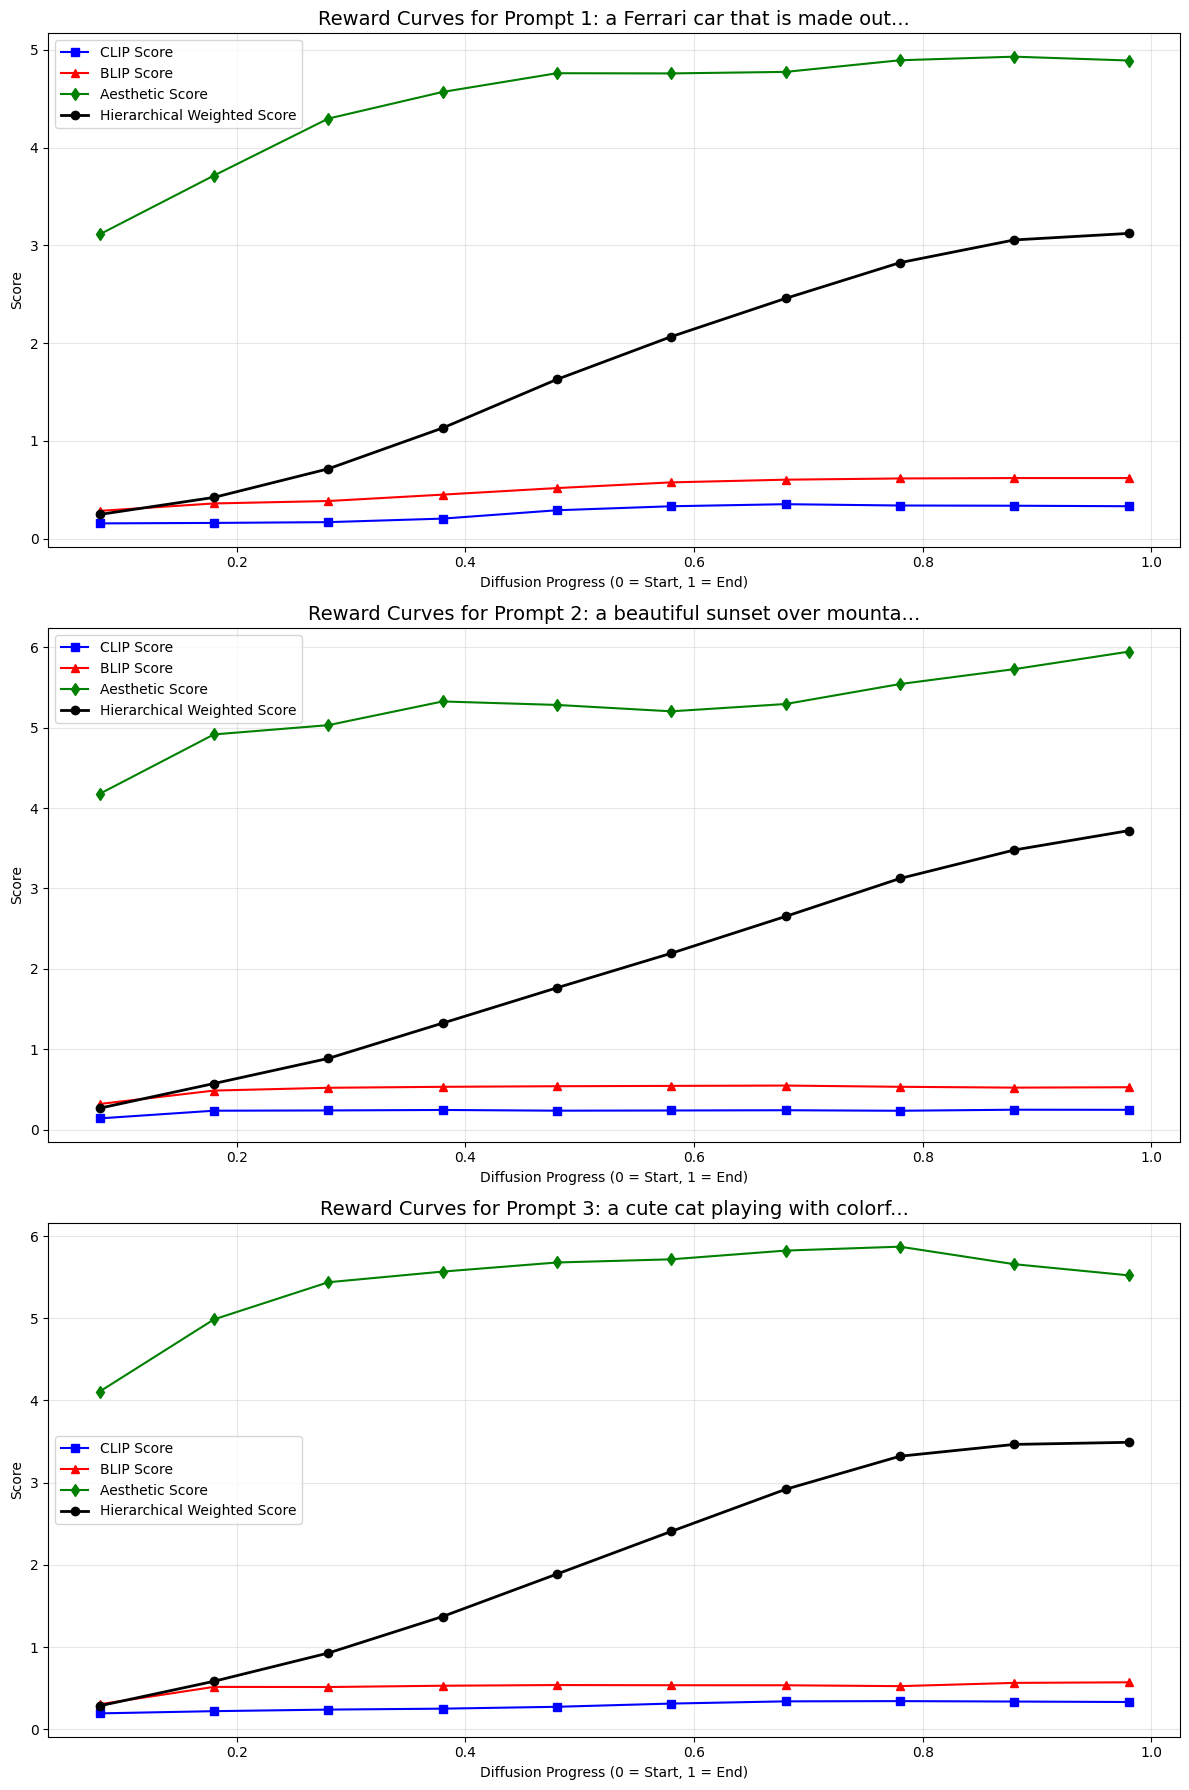


--- 评估完成 ---


In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
import ImageReward as reward
from PIL import Image
import tempfile
from diffusers import FluxPipeline

# 确保 ImageReward 模型的设备与 Flux.1 保持一致
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# print("--- 步骤1：加载奖励模型 ---")
# reward_model = reward.load("ImageReward-v1.0", device=DEVICE)
# # For the new functionality, you'll need three separate reward models
# clip_score_rm = reward.load("ImageReward-v1.0", device=DEVICE) # Assuming this is CLIP-based
# blip_score_rm = reward.load("ImageReward-v1.0", device=DEVICE) # Assuming this is BLIP-based
# aes_score_rm = reward.load("ImageReward-v1.0", device=DEVICE) # Assuming this is aesthetic-based
# print("ImageReward models loaded successfully.")

# 权重配置 - 模拟不同评估维度
weight_config = {
    'start': [0.5, 0.5, 0.0],  # [CLIP-style, BLIP-style, Aesthetic-style]
    'end': [0.2, 0.2, 0.6]
}

def smooth_weight_transition(t: float, method: str = 'cosine') -> List[float]:
    """
    设计平滑权重过渡函数
    """
    start_weights = np.array(weight_config['start'])
    end_weights = np.array(weight_config['end'])

    if method == 'linear':
        alpha = t
    elif method == 'cosine':
        alpha = (1 - np.cos(np.pi * t)) / 2
    elif method == 'sigmoid':
        alpha = 1 / (1 + np.exp(-10 * (t - 0.5)))
    elif method == 'exponential':
        alpha = t ** 2
    else:
        alpha = t

    weights = start_weights + alpha * (end_weights - start_weights)
    weights = weights / np.sum(weights)

    return weights.tolist()

def compute_hierarchical_reward(prompt: str, image: Image.Image, timestep: int,
                              total_steps: int = 50, method: str = 'cosine') -> Dict[str, float]:
    """
    计算分阶段奖励
    """
    t = timestep / total_steps
    weights = smooth_weight_transition(t, method)

    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp_file:
        image.save(tmp_file, format='JPEG')
        image_path = tmp_file.name

    # Removed os.unlink(image_path) here. The temporary file will persist until the program finishes.
    # We will use the same image path for all score models
    clip_score = clip_score_rm.score(prompt, image_path)
    blip_score = blip_score_rm.score(prompt, image_path)
    aes_score = aes_score_rm.score(prompt, image_path)
    os.unlink(image_path) # Move the deletion here after all scores are calculated.

    # 计算加权综合分数
    hierarchical_score = (weights[0] * clip_score +
                          weights[1] * blip_score +
                          weights[2] * aes_score)

    return {
        'clip_score': float(clip_score),
        'blip_score': float(blip_score),
        'aesthetic_score': float(aes_score),
        'hierarchical_score': float(hierarchical_score),
        'weights': weights,
        'timestep_ratio': t
    }

# 2. 定义回调函数，它将获取潜在图像，解码并计算奖励
all_results = {}
total_steps = 50
current_prompt_results = []
image_height = 1024
image_width = 1024

def save_and_evaluate_intermediate_images(pipe, step, timestep, callback_kwargs, prompt, total_steps, height, width):
    global current_prompt_results

    if (step + 1) % 5 == 0:
        latents = callback_kwargs.get("latents")
        if latents is not None:
            save_dir = "intermediate_rewards"
            os.makedirs(save_dir, exist_ok=True)

            with torch.no_grad():
                latents_unpacked = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
                scaled_latents = (latents_unpacked / pipe.vae.config.scaling_factor) + pipe.vae.config.shift_factor
                image_tensor = pipe.vae.decode(scaled_latents.to(pipe.vae.dtype), return_dict=False)[0].cpu()
                image = pipe.image_processor.postprocess(image_tensor, output_type="pil")[0]

            reward_info = compute_hierarchical_reward(
                prompt=prompt,
                image=image,
                timestep=step,
                total_steps=total_steps,
                method='cosine'
            )
            current_prompt_results.append(reward_info)

            file_path = os.path.join(save_dir, f"step_{step+1:04d}_{reward_info['hierarchical_score']:.4f}.png")
            image.save(file_path)
            print('---------------------------------------------')
            print(f"--- 步骤 {step+1}: score = {reward_info['hierarchical_score']:.4f}, Saved to {file_path} ---")
            print(f"--- 步骤 {step+1}: clip_score = {reward_info['clip_score']:.4f}, Saved to {file_path} ---")
            print(f"--- 步骤 {step+1}: blip_score = {reward_info['blip_score']:.4f}, Saved to {file_path} ---")
            print(f"--- 步骤 {step+1}: aesthetic_score = {reward_info['aesthetic_score']:.4f}, Saved to {file_path} ---")

    return {}

def plot_reward_curves(all_results: Dict[str, List[Dict]]):
    """
    绘制指定的所有奖励曲线
    """
    num_prompts = len(all_results)
    if num_prompts == 0:
        print("没有结果可以绘制。")
        return

    fig, axes = plt.subplots(num_prompts, 1, figsize=(12, 6 * num_prompts))

    if num_prompts == 1:
        axes = [axes]

    for idx, (prompt_id, results) in enumerate(all_results.items()):
        ax = axes[idx]
        if not results:
            continue

        timesteps = [r['timestep_ratio'] for r in results]
        clip_scores = [r['clip_score'] for r in results]
        blip_scores = [r['blip_score'] for r in results]
        aes_scores = [r['aesthetic_score'] for r in results]
        hierarchical_scores = [r['hierarchical_score'] for r in results]

        ax.plot(timesteps, clip_scores, marker='s', linestyle='-', label='CLIP Score', color='blue')
        ax.plot(timesteps, blip_scores, marker='^', linestyle='-', label='BLIP Score', color='red')
        ax.plot(timesteps, aes_scores, marker='d', linestyle='-', label='Aesthetic Score', color='green')
        ax.plot(timesteps, hierarchical_scores, marker='o', linestyle='-', label='Hierarchical Weighted Score', color='black', linewidth=2)

        ax.set_title(f"Reward Curves for {prompt_id}", fontsize=14)
        ax.set_xlabel("Diffusion Progress (0 = Start, 1 = End)")
        ax.set_ylabel("Score")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# # --- 主脚本开始 ---
# print("\n--- 步骤2：加载 Flux.1 模型 ---")
# pipe = FluxPipeline.from_pretrained(
#     "black-forest-labs/FLUX.1-schnell",
#     torch_dtype=torch.bfloat16 if DEVICE == "cuda" else torch.float32
# )
# pipe = pipe.to(DEVICE)

if DEVICE == "cuda":
    pipe.enable_model_cpu_offload()

print("Flux.1 pipeline loaded successfully.")

# 准备测试提示词
prompts = [
    "a Ferrari car that is made out of wood",
    "a beautiful sunset over mountains with vibrant colors",
    "a cute cat playing with colorful yarn ball",
]

print(f"\n--- 步骤3：开始生成图像并进行分阶段评估 ---")
print(f"Using {len(prompts)} test prompts.")

for i, prompt in enumerate(prompts):
    print(f"\n--- Processing prompt {i+1}/{len(prompts)} ---")

    current_prompt_results = []

    image_height = pipe.default_sample_size * pipe.vae_scale_factor
    image_width = pipe.default_sample_size * pipe.vae_scale_factor

    result_image = pipe(
        prompt=prompt,
        generator=torch.Generator(device=DEVICE).manual_seed(42 + i),
        num_inference_steps=total_steps,
        guidance_scale=3.5,
        height=image_height,
        width=image_width,
        callback_on_step_end=lambda p, s, t, kw: save_and_evaluate_intermediate_images(p, s, t, kw, prompt, total_steps, image_height, image_width),
        callback_on_step_end_tensor_inputs=["latents"]
    ).images[0]

    all_results[f"Prompt {i+1}: {prompt[:30]}..."] = current_prompt_results

    final_image_path = f"final_image_{i+1}.png"
    result_image.save(final_image_path)
    print(f"Final image saved to {final_image_path}")

print(f"\n--- 步骤4：绘制结果 ---")
plot_reward_curves(all_results)
print("\n--- 评估完成 ---")

Flux.1 pipeline loaded successfully.

--- 步骤3：开始生成图像并进行分阶段评估 ---
Using 3 test prompts.

--- Processing prompt 1/3 ---


  0%|          | 0/50 [00:00<?, ?it/s]

---------------------------------------------
--- 步骤 5: hierarchical_score = 0.2477, Saved to intermediate_rewards/step_0005_0.2477.png ---
--- 步骤 5: clip_score = 0.1565 ---
--- 步骤 5: blip_score = 0.2843 ---
--- 步骤 5: aesthetic_score = 3.1132 ---
---------------------------------------------
--- 步骤 10: hierarchical_score = 0.4222, Saved to intermediate_rewards/step_0010_0.4222.png ---
--- 步骤 10: clip_score = 0.1613 ---
--- 步骤 10: blip_score = 0.3604 ---
--- 步骤 10: aesthetic_score = 3.7149 ---
---------------------------------------------
--- 步骤 15: hierarchical_score = 0.7146, Saved to intermediate_rewards/step_0015_0.7146.png ---
--- 步骤 15: clip_score = 0.1692 ---
--- 步骤 15: blip_score = 0.3853 ---
--- 步骤 15: aesthetic_score = 4.2976 ---
---------------------------------------------
--- 步骤 20: hierarchical_score = 1.1321, Saved to intermediate_rewards/step_0020_1.1321.png ---
--- 步骤 20: clip_score = 0.2053 ---
--- 步骤 20: blip_score = 0.4506 ---
--- 步骤 20: aesthetic_score = 4.5701 ---


  0%|          | 0/50 [00:00<?, ?it/s]

---------------------------------------------
--- 步骤 5: hierarchical_score = 0.2654, Saved to intermediate_rewards/step_0005_0.2654.png ---
--- 步骤 5: clip_score = 0.1387 ---
--- 步骤 5: blip_score = 0.3177 ---
--- 步骤 5: aesthetic_score = 4.1761 ---
---------------------------------------------
--- 步骤 10: hierarchical_score = 0.5722, Saved to intermediate_rewards/step_0010_0.5722.png ---
--- 步骤 10: clip_score = 0.2343 ---
--- 步骤 10: blip_score = 0.4846 ---
--- 步骤 10: aesthetic_score = 4.9157 ---
---------------------------------------------
--- 步骤 15: hierarchical_score = 0.8846, Saved to intermediate_rewards/step_0015_0.8846.png ---
--- 步骤 15: clip_score = 0.2375 ---
--- 步骤 15: blip_score = 0.5194 ---
--- 步骤 15: aesthetic_score = 5.0310 ---
---------------------------------------------
--- 步骤 20: hierarchical_score = 1.3236, Saved to intermediate_rewards/step_0020_1.3236.png ---
--- 步骤 20: clip_score = 0.2434 ---
--- 步骤 20: blip_score = 0.5315 ---
--- 步骤 20: aesthetic_score = 5.3259 ---


  0%|          | 0/50 [00:00<?, ?it/s]

---------------------------------------------
--- 步骤 5: hierarchical_score = 0.2847, Saved to intermediate_rewards/step_0005_0.2847.png ---
--- 步骤 5: clip_score = 0.1930 ---
--- 步骤 5: blip_score = 0.3037 ---
--- 步骤 5: aesthetic_score = 4.1079 ---
---------------------------------------------
--- 步骤 10: hierarchical_score = 0.5834, Saved to intermediate_rewards/step_0010_0.5834.png ---
--- 步骤 10: clip_score = 0.2201 ---
--- 步骤 10: blip_score = 0.5153 ---
--- 步骤 10: aesthetic_score = 4.9863 ---
---------------------------------------------
--- 步骤 15: hierarchical_score = 0.9270, Saved to intermediate_rewards/step_0015_0.9270.png ---
--- 步骤 15: clip_score = 0.2391 ---
--- 步骤 15: blip_score = 0.5137 ---
--- 步骤 15: aesthetic_score = 5.4383 ---
---------------------------------------------
--- 步骤 20: hierarchical_score = 1.3715, Saved to intermediate_rewards/step_0020_1.3715.png ---
--- 步骤 20: clip_score = 0.2505 ---
--- 步骤 20: blip_score = 0.5295 ---
--- 步骤 20: aesthetic_score = 5.5680 ---


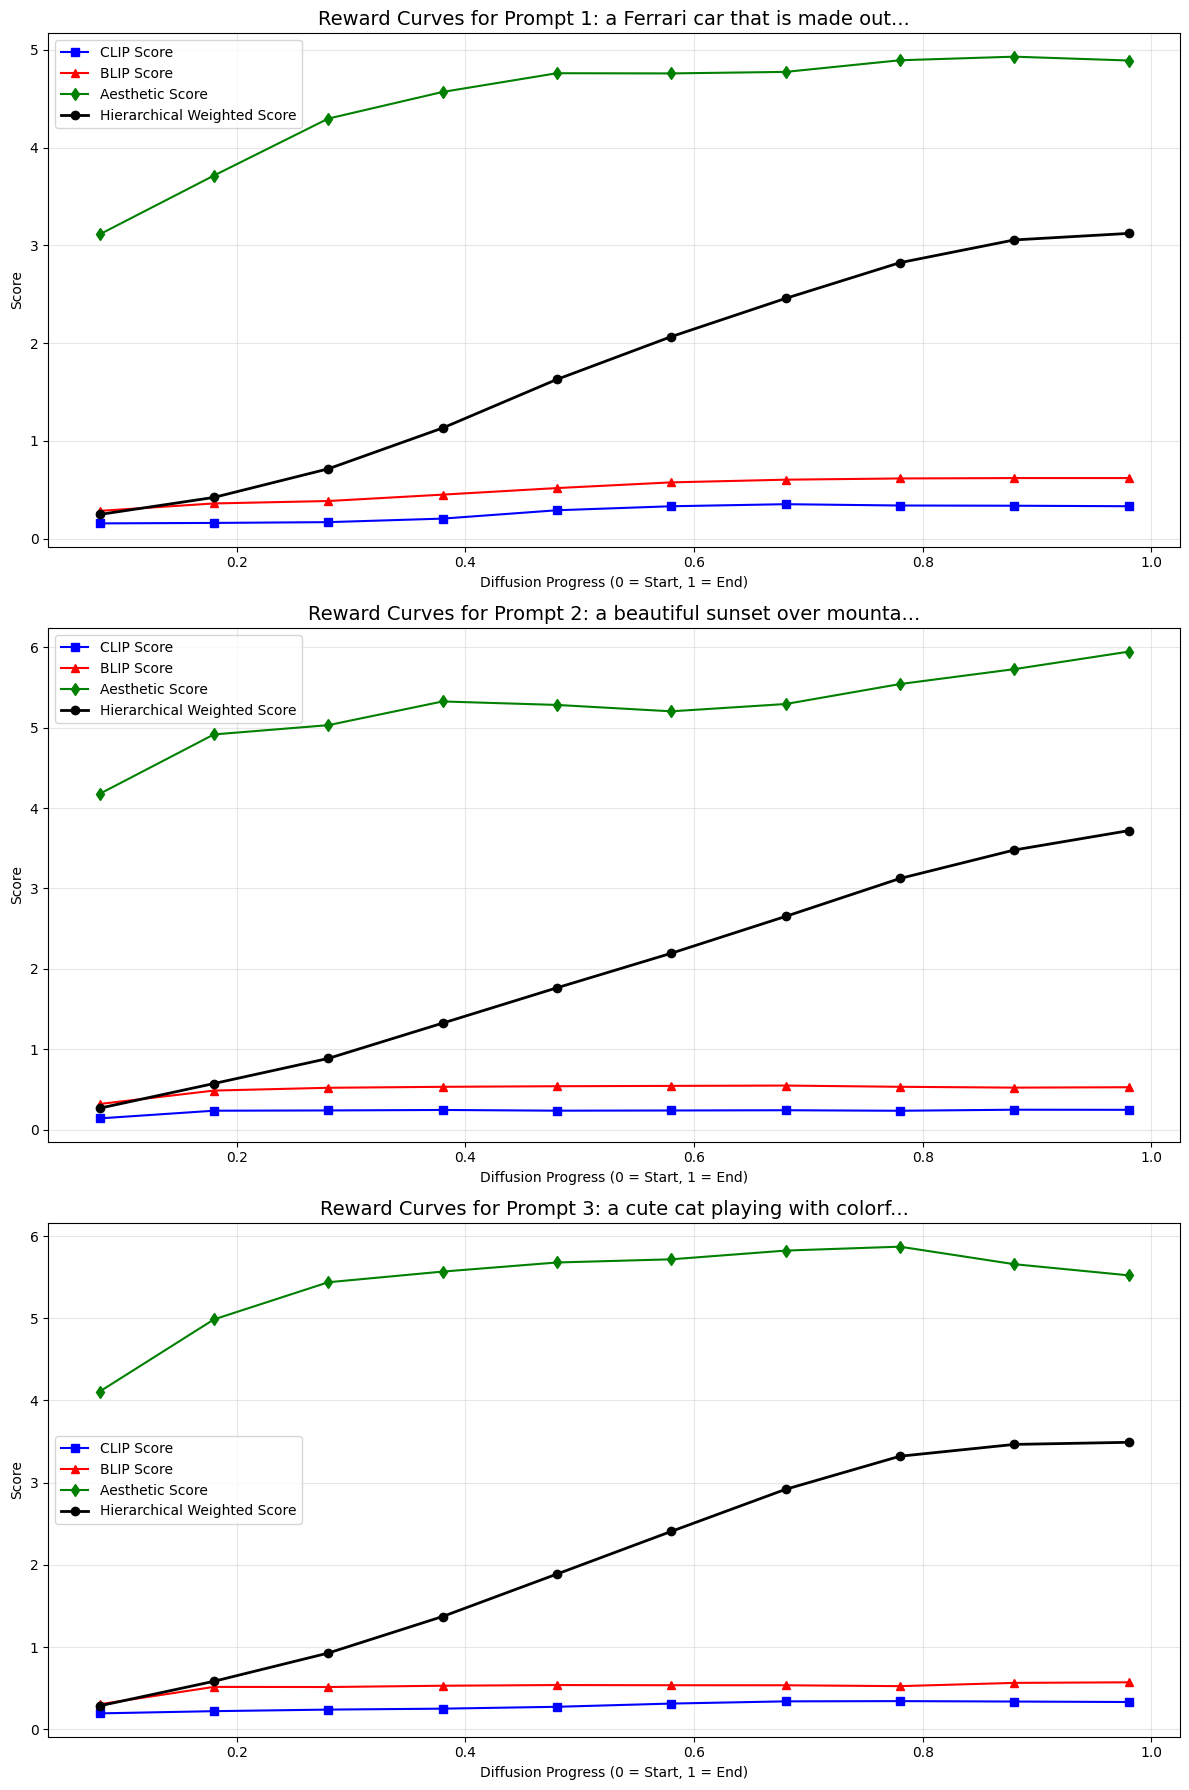

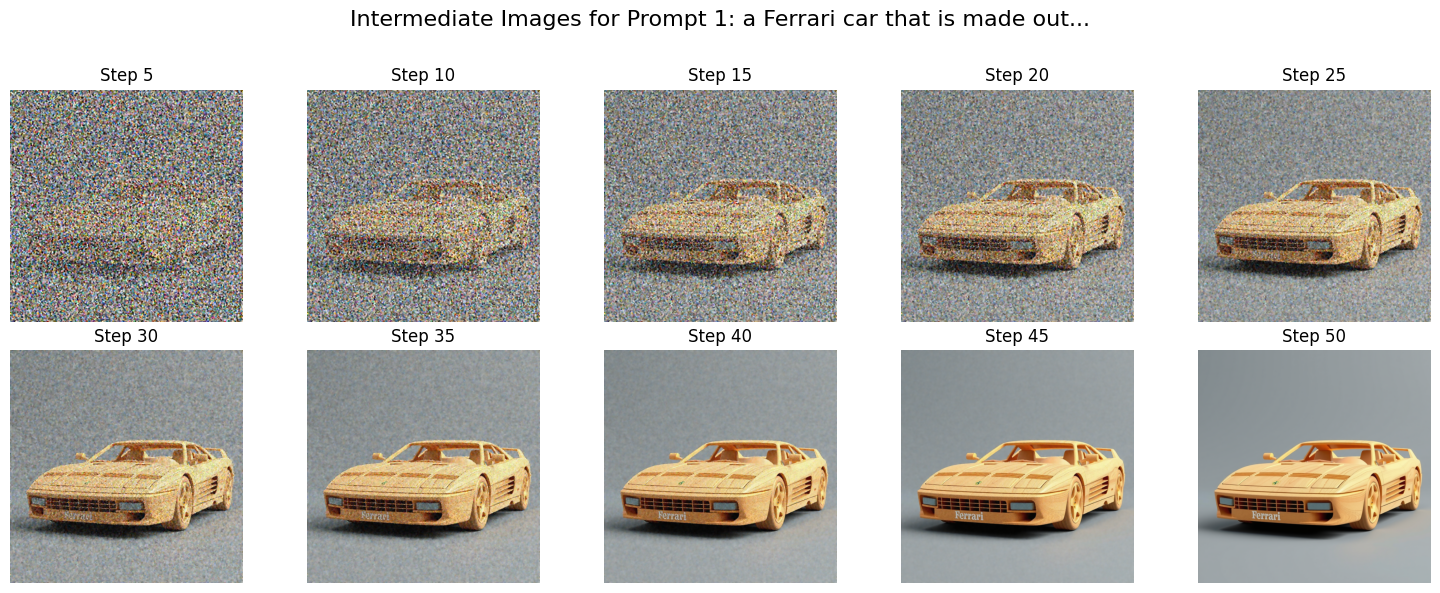

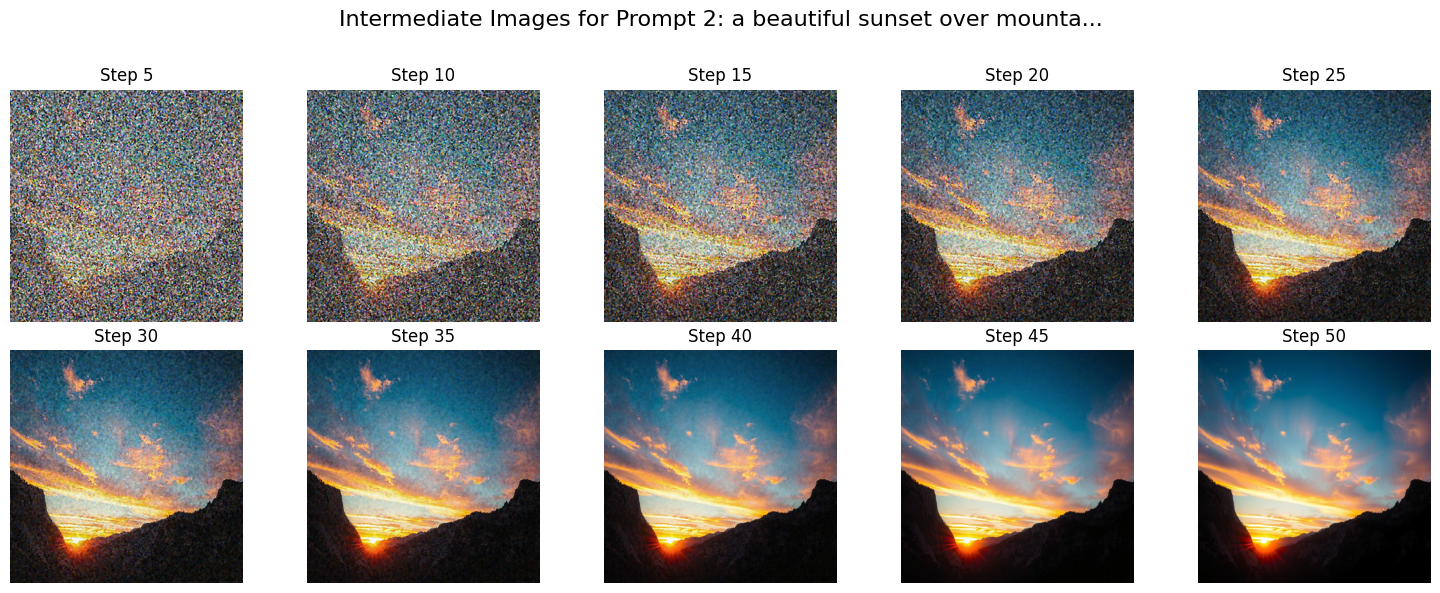

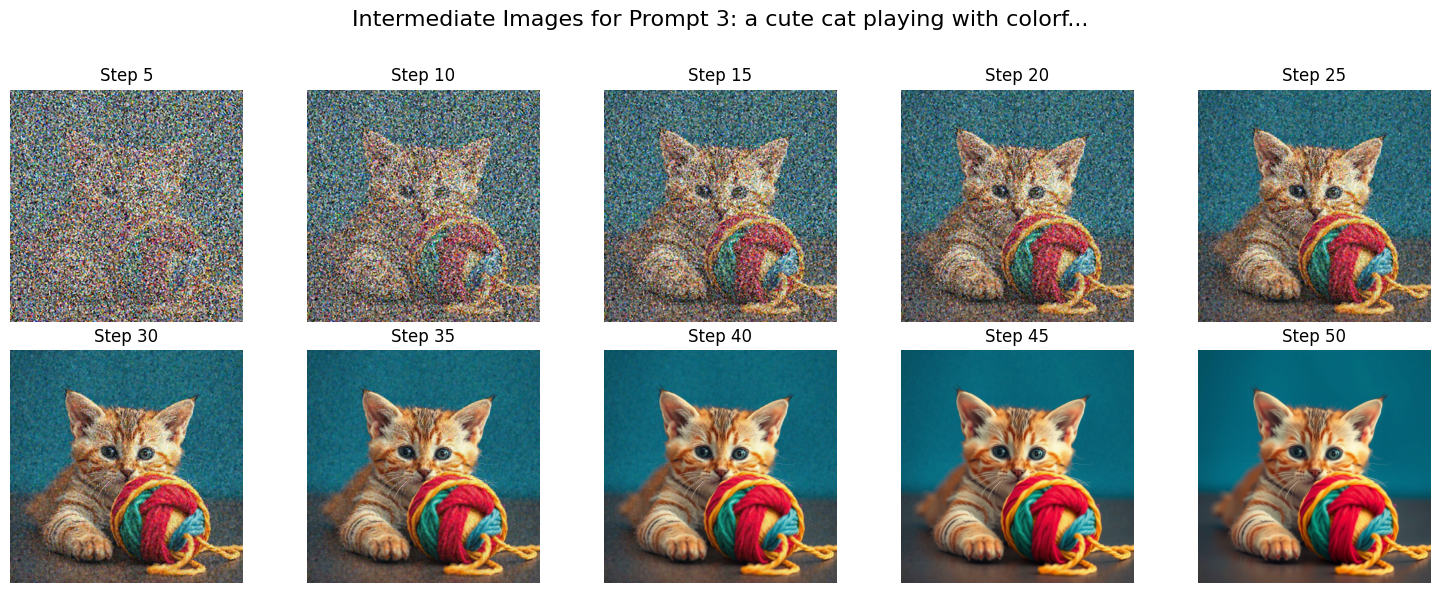


--- 评估完成 ---


In [25]:
# 前面要加载好pipe，clip_score_rm，blip_score_rm，aes_score_rm
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
import ImageReward as reward
from PIL import Image
import tempfile
from diffusers import FluxPipeline

# 确保 ImageReward 模型的设备与 Flux.1 保持一致
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


if DEVICE == "cuda":
    pipe.enable_model_cpu_offload()
print("Flux.1 pipeline loaded successfully.")

# 权重配置 - 模拟不同评估维度
weight_config = {
    'start': [0.5, 0.5, 0.0],  # [CLIP-style, BLIP-style, Aesthetic-style]
    'end': [0.2, 0.2, 0.6]
}

def smooth_weight_transition(t: float, method: str = 'cosine') -> List[float]:
    """
    设计平滑权重过渡函数
    """
    start_weights = np.array(weight_config['start'])
    end_weights = np.array(weight_config['end'])

    if method == 'linear':
        alpha = t
    elif method == 'cosine':
        alpha = (1 - np.cos(np.pi * t)) / 2
    elif method == 'sigmoid':
        alpha = 1 / (1 + np.exp(-10 * (t - 0.5)))
    elif method == 'exponential':
        alpha = t ** 2
    else:
        alpha = t

    weights = start_weights + alpha * (end_weights - start_weights)
    weights = weights / np.sum(weights)

    return weights.tolist()

def compute_hierarchical_reward(prompt: str, image: Image.Image, timestep: int,
                              total_steps: int = 50, method: str = 'cosine') -> Dict[str, float]:
    """
    计算分阶段奖励
    """
    t = timestep / total_steps
    weights = smooth_weight_transition(t, method)

    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp_file:
        image.save(tmp_file, format='JPEG')
        image_path = tmp_file.name

    clip_score = clip_score_rm.score(prompt, image_path)
    blip_score = blip_score_rm.score(prompt, image_path)
    aes_score = aes_score_rm.score(prompt, image_path)
    os.unlink(image_path) # Move the deletion here after all scores are calculated.

    # 计算加权综合分数
    hierarchical_score = (weights[0] * clip_score +
                          weights[1] * blip_score +
                          weights[2] * aes_score)

    return {
        'clip_score': float(clip_score),
        'blip_score': float(blip_score),
        'aesthetic_score': float(aes_score),
        'hierarchical_score': float(hierarchical_score),
        'weights': weights,
        'timestep_ratio': t
    }

# 2. 定义回调函数，它将获取潜在图像，解码并计算奖励
all_results = {}
intermediate_images = {} # 新增一个字典来存储中间图像
total_steps = 50
current_prompt_results = []
current_images = []
image_height = 1024
image_width = 1024

def save_and_evaluate_intermediate_images(pipe, step, timestep, callback_kwargs, prompt, total_steps, height, width):
    global current_prompt_results
    global current_images

    if (step + 1) % 5 == 0:
        latents = callback_kwargs.get("latents")
        if latents is not None:
            save_dir = "intermediate_rewards"
            os.makedirs(save_dir, exist_ok=True)

            with torch.no_grad():
                latents_unpacked = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
                scaled_latents = (latents_unpacked / pipe.vae.config.scaling_factor) + pipe.vae.config.shift_factor
                image_tensor = pipe.vae.decode(scaled_latents.to(pipe.vae.dtype), return_dict=False)[0].cpu()
                image = pipe.image_processor.postprocess(image_tensor, output_type="pil")[0]

            reward_info = compute_hierarchical_reward(
                prompt=prompt,
                image=image,
                timestep=step,
                total_steps=total_steps,
                method='cosine'
            )
            current_prompt_results.append(reward_info)
            current_images.append(image)

            file_path = os.path.join(save_dir, f"step_{step+1:04d}_{reward_info['hierarchical_score']:.4f}.png")
            image.save(file_path)

            # 🚩 关键修改：打印所有分数
            print('---------------------------------------------')
            print(f"--- 步骤 {step+1}: hierarchical_score = {reward_info['hierarchical_score']:.4f}, Saved to {file_path} ---")
            print(f"--- 步骤 {step+1}: clip_score = {reward_info['clip_score']:.4f} ---")
            print(f"--- 步骤 {step+1}: blip_score = {reward_info['blip_score']:.4f} ---")
            print(f"--- 步骤 {step+1}: aesthetic_score = {reward_info['aesthetic_score']:.4f} ---")
    return {}

def plot_reward_curves(all_results: Dict[str, List[Dict]]):
    """
    绘制指定的所有奖励曲线
    """
    num_prompts = len(all_results)
    if num_prompts == 0:
        print("没有结果可以绘制。")
        return

    fig, axes = plt.subplots(num_prompts, 1, figsize=(12, 6 * num_prompts))
    if num_prompts == 1:
        axes = [axes]

    for idx, (prompt_id, results) in enumerate(all_results.items()):
        ax = axes[idx]
        if not results:
            continue

        timesteps = [r['timestep_ratio'] for r in results]
        clip_scores = [r['clip_score'] for r in results]
        blip_scores = [r['blip_score'] for r in results]
        aes_scores = [r['aesthetic_score'] for r in results]
        hierarchical_scores = [r['hierarchical_score'] for r in results]

        ax.plot(timesteps, clip_scores, marker='s', linestyle='-', label='CLIP Score', color='blue')
        ax.plot(timesteps, blip_scores, marker='^', linestyle='-', label='BLIP Score', color='red')
        ax.plot(timesteps, aes_scores, marker='d', linestyle='-', label='Aesthetic Score', color='green')
        ax.plot(timesteps, hierarchical_scores, marker='o', linestyle='-', label='Hierarchical Weighted Score', color='black', linewidth=2)

        ax.set_title(f"Reward Curves for {prompt_id}", fontsize=14)
        ax.set_xlabel("Diffusion Progress (0 = Start, 1 = End)")
        ax.set_ylabel("Score")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_intermediate_images(images_dict: Dict[str, List[Image.Image]]):
    """
    绘制所有提示词的中间图像网格
    """
    if not images_dict:
        print("没有中间图像可以绘制。")
        return

    for prompt_id, images in images_dict.items():
        num_images = len(images)
        if num_images == 0:
            continue

        cols = 5
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        fig.suptitle(f"Intermediate Images for {prompt_id}", fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(images[i])
                ax.set_title(f"Step {i*5 + 5}")
                ax.axis('off')
            else:
                ax.set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# --- 主脚本开始 ---
print(f"\n--- 步骤3：开始生成图像并进行分阶段评估 ---")
prompts = [
    "a Ferrari car that is made out of wood",
    "a beautiful sunset over mountains with vibrant colors",
    "a cute cat playing with colorful yarn ball",
]
print(f"Using {len(prompts)} test prompts.")

for i, prompt in enumerate(prompts):
    print(f"\n--- Processing prompt {i+1}/{len(prompts)} ---")

    current_prompt_results = []
    current_images = []

    image_height = pipe.default_sample_size * pipe.vae_scale_factor
    image_width = pipe.default_sample_size * pipe.vae_scale_factor

    result_image = pipe(
        prompt=prompt,
        generator=torch.Generator(device=DEVICE).manual_seed(42 + i),
        num_inference_steps=total_steps,
        guidance_scale=3.5,
        height=image_height,
        width=image_width,
        callback_on_step_end=lambda p, s, t, kw: save_and_evaluate_intermediate_images(p, s, t, kw, prompt, total_steps, image_height, image_width),
        callback_on_step_end_tensor_inputs=["latents"]
    ).images[0]

    all_results[f"Prompt {i+1}: {prompt[:30]}..."] = current_prompt_results
    intermediate_images[f"Prompt {i+1}: {prompt[:30]}..."] = current_images

    final_image_path = f"final_image_{i+1}.png"
    result_image.save(final_image_path)
    print(f"Final image saved to {final_image_path}")

print(f"\n--- 步骤4：绘制结果 ---")
plot_reward_curves(all_results)
plot_intermediate_images(intermediate_images)

print("\n--- 评估完成 ---")

In [ ]:
class LatentSpaceRMTuner:
    """潜在空间奖励模型微调器"""

    def __init__(self, base_rm):
        self.base_rm = base_rm

    def create_latent_adapter(self, latent_dim: int = 512):
        """创建潜在空间适配器"""
        class LatentAdapter(nn.Module):
            def __init__(self, input_dim, output_dim):
                super().__init__()
                self.adapter = nn.Sequential(
                    nn.Linear(input_dim, 256),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim)
                )

            def forward(self, x):
                return self.adapter(x)

        return LatentAdapter(latent_dim, 1)

    def prepare_latent_training_data(self, richhf_dataset, vae_encoder):
        """
        准备潜在空间训练数据
        解决OOD问题的关键是在潜在空间中训练奖励模型
        """
        latent_features = []
        reward_scores = []

        for item in richhf_dataset:
            # 将图像编码到潜在空间
            with torch.no_grad():
                latent = vae_encoder.encode(item['image']).latent_dist.sample()
                latent = latent * 0.18215  # FLUX的缩放因子

            # 计算多维度奖励分数作为监督信号
            clip_score = self.base_rm.clip_score_rm.score(item['caption'], item['image'])
            blip_score = self.base_rm.blip_score_rm.score(item['caption'], item['image'])
            aes_score = self.base_rm.aes_score_rm.score(item['caption'], item['image'])

            # 综合分数作为训练目标
            combined_score = 0.3 * clip_score + 0.3 * blip_score + 0.4 * aes_score

            latent_features.append(latent.flatten())
            reward_scores.append(combined_score)

        return torch.stack(latent_features), torch.tensor(reward_scores)

    def train_latent_rm(self, train_loader, val_loader, epochs=100):
        """训练潜在空间奖励模型"""
        latent_dim = train_loader.dataset[0][0].shape[0]
        model = self.create_latent_adapter(latent_dim)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.MSELoss()

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # 训练阶段
            model.train()
            train_loss = 0
            for batch_latent, batch_scores in train_loader:
                optimizer.zero_grad()
                pred_scores = model(batch_latent).squeeze()
                loss = criterion(pred_scores, batch_scores)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # 验证阶段
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_latent, batch_scores in val_loader:
                    pred_scores = model(batch_latent).squeeze()
                    loss = criterion(pred_scores, batch_scores)
                    val_loss += loss.item()

            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

        return model, train_losses, val_losses